<a href="https://colab.research.google.com/github/PRIYANGA-SELVAPERUMAL/Multilingual_Hate_Speech_Detection/blob/main/7_low_res_hs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("priyangaselvaperumal/7-low-resource-languages")

print("Path to dataset files:", path)

100%|██████████| 6.27M/6.27M [00:00<00:00, 30.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/priyangaselvaperumal/7-low-resource-languages/versions/1


In [2]:
import os

base_path = "/root/.cache/kagglehub/datasets/priyangaselvaperumal/7-low-resource-languages/versions/1"
print(os.listdir(base_path))


['mpox 7 languages dataset.xlsx']


In [3]:
import pandas as pd

file_path = "/root/.cache/kagglehub/datasets/priyangaselvaperumal/7-low-resource-languages/versions/1/mpox 7 languages dataset.xlsx"
xls = pd.ExcelFile(file_path)

# List all sheet names (in case there are multiple languages or splits)
print(xls.sheet_names)


['Worksheet']


In [4]:
df = pd.read_excel(xls, sheet_name='Worksheet')
print(df.head())
print(df.columns)


       Post ID                                   Post description        Date  \
0  CgXDOaQDvGm  “I have decided that the global #monkeypox out...  07/23/2022   
1  CgXpRmMIdzG  In light of the evolving monkeypox outbreak wi...  07/23/2022   
2  CgXMyIjP34S  #LinkInBio | The World Health Organization sai...  07/23/2022   
3  CgXaFGDsevq  If you've been hearing about monkeypox and wan...  07/23/2022   
4  CgX3rATJTXd  Our horrific experience with MONKEYPOX…\n\n#mo...  07/23/2022   

  Language                        Translated Post Description Sentiment  \
0  english  “I have decided that the global #monkeypox out...   neutral   
1  english  In light of the evolving monkeypox outbreak wi...   neutral   
2  english  #LinkInBio | The World Health Organization sai...      fear   
3  english  If you've been hearing about monkeypox and wan...   neutral   
4  english  Our horrific experience with MONKEYPOX…\n\n#mo...      fear   

       Hate           Stress or Anxiety  
0  Not Hate     Stre

In [5]:
print(df['Hate'].value_counts())


Hate
Not Hate    31490
Hate         1682
Name: count, dtype: int64


In [7]:
from imblearn.over_sampling import RandomOverSampler

# Separate the features (text) and labels (Hate/Not Hate)
X = df['Post description']  # The text column
y = df['Hate']  # The label column

# Apply RandomOversampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1,1), y)

# Create a balanced DataFrame
df_balanced = pd.DataFrame({'Post description': X_resampled.flatten(), 'Hate': y_resampled})

# Check the new distribution
print(df_balanced['Hate'].value_counts())


Hate
Not Hate    31490
Hate        31490
Name: count, dtype: int64


In [8]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

df_balanced["Post description"] = df_balanced["Post description"].apply(preprocess_text)


In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_balanced["label"] = le.fit_transform(df_balanced["Hate"])  # Not Hate = 0, Hate = 1


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df_balanced["Post description"],
    df_balanced["label"],
    test_size=0.2,
    stratify=df_balanced["label"],
    random_state=42
)


In [11]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

def tokenize_data(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

X_train_enc = tokenize_data(X_train)
X_val_enc = tokenize_data(X_val)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

class HateDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels.tolist())

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels[idx]
        }

    def __len__(self):
        return len(self.labels)

train_dataset = HateDataset(X_train_enc, y_train)
val_dataset = HateDataset(X_val_enc, y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [13]:
import torch.nn as nn
from transformers import BertModel

class BertBiLSTMAttention(nn.Module):
    def __init__(self, bert_model_name="bert-base-multilingual-cased", hidden_size=256, num_classes=2):
        super(BertBiLSTMAttention, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.lstm = nn.LSTM(
            input_size=768,
            hidden_size=hidden_size,
            num_layers=2,
            dropout=0.3,
            bidirectional=True,
            batch_first=True
        )
        self.attention = nn.Linear(hidden_size * 2, 1)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_output.last_hidden_state  # (batch_size, seq_len, 768)

        lstm_output, _ = self.lstm(sequence_output)  # (batch_size, seq_len, hidden_size*2)

        # Attention mechanism
        attn_weights = torch.softmax(self.attention(lstm_output), dim=1)  # (batch_size, seq_len, 1)
        context = torch.sum(attn_weights * lstm_output, dim=1)  # (batch_size, hidden_size*2)

        output = self.classifier(context)  # (batch_size, num_classes)
        return output


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertBiLSTMAttention().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

EPOCHS = 4

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(all_labels, all_preds)
    train_prec = precision_score(all_labels, all_preds)
    train_rec = recall_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds)

    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss: {total_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, Rec: {train_rec:.4f}, F1: {train_f1:.4f}")



Epoch 1
Train Loss: 1235.1319
Train Acc: 0.8264, Prec: 0.8494, Rec: 0.7934, F1: 0.8204

Epoch 2
Train Loss: 967.6322
Train Acc: 0.8642, Prec: 0.8839, Rec: 0.8386, F1: 0.8607

Epoch 3
Train Loss: 873.6140
Train Acc: 0.8781, Prec: 0.8991, Rec: 0.8517, F1: 0.8748

Epoch 4
Train Loss: 792.0244
Train Acc: 0.8925, Prec: 0.9177, Rec: 0.8623, F1: 0.8891


Val Acc: 0.9216, Prec: 0.9492, Rec: 0.8909, F1: 0.9192


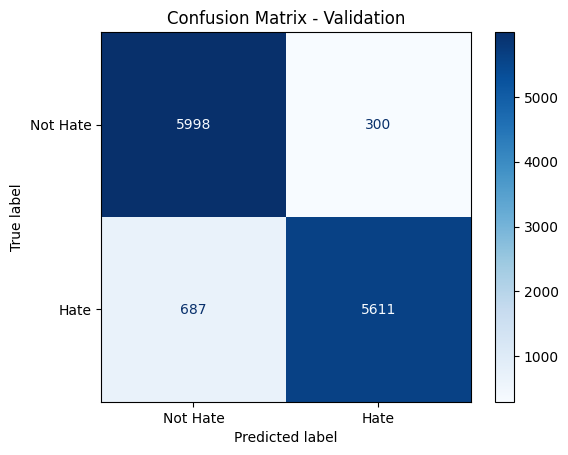

In [18]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set model to evaluation mode
model.eval()
val_preds = []
val_labels = []

# Validation loop
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Metrics calculation
val_acc = accuracy_score(val_labels, val_preds)
val_prec = precision_score(val_labels, val_preds)
val_rec = recall_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds)

print(f"Val Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, Rec: {val_rec:.4f}, F1: {val_f1:.4f}")

# Confusion Matrix plot
cm = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hate", "Hate"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Validation")
plt.show()



In [19]:
# Save model state dict
torch.save(model.state_dict(), "multilingual_hate_speech_model.pt")
print("✅ Model saved as multilingual_hate_speech_model.pt")


✅ Model saved as multilingual_hate_speech_model.pt


In [22]:
print(df.columns)


Index(['Post ID', 'Post description', 'Date', 'Language',
       'Translated Post Description', 'Sentiment', 'Hate',
       'Stress or Anxiety'],
      dtype='object')


In [27]:
import torch
from transformers import BertTokenizer

# Define your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model.load_state_dict(torch.load("multilingual_hate_speech_model.pt", map_location=device))
model.to(device)
model.eval()

# Languages to sample
languages = ['english', 'swahili', 'malayalam', 'thai', 'tamil', 'afrikaans', 'tagalog']

# Loop through languages and show prediction
for lang in languages:
    try:
        row = df[df['Language'] == lang].iloc[0]
        text = row['Post description']

        # Handle the label properly whether it's numeric or string
        if isinstance(row['Hate'], (int, float)):
            true_label = int(row['Hate'])
            true_label_text = 'Hate' if true_label == 1 else 'Not Hate'
        else:
            # If it's a string like "Hate" or "Not Hate"
            true_label_text = row['Hate']
            true_label = 1 if true_label_text == 'Hate' else 0

        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():  # Add this for inference
            output = model(**inputs)

        logits = output.logits if hasattr(output, 'logits') else output
        pred = torch.argmax(logits, dim=1).item()
        pred_text = 'Hate' if pred == 1 else 'Not Hate'

        print(f"[{lang.upper()}] Text: {text}")
        print(f"True Label : {true_label_text}")
        print(f"Predicted  : {pred_text}\n")

    except IndexError:
        print(f"[{lang.upper()}] No sample available in 'Post description'.\n")
    except Exception as e:
        print(f"[{lang.upper()}] Error processing: {e}\n")

[ENGLISH] Error processing: BertBiLSTMAttention.forward() got an unexpected keyword argument 'token_type_ids'

[SWAHILI] Error processing: BertBiLSTMAttention.forward() got an unexpected keyword argument 'token_type_ids'

[MALAYALAM] Error processing: BertBiLSTMAttention.forward() got an unexpected keyword argument 'token_type_ids'

[THAI] Error processing: BertBiLSTMAttention.forward() got an unexpected keyword argument 'token_type_ids'

[TAMIL] Error processing: BertBiLSTMAttention.forward() got an unexpected keyword argument 'token_type_ids'

[AFRIKAANS] Error processing: BertBiLSTMAttention.forward() got an unexpected keyword argument 'token_type_ids'

[TAGALOG] Error processing: BertBiLSTMAttention.forward() got an unexpected keyword argument 'token_type_ids'



In [29]:
import torch
import torch.nn as nn
from transformers import BertModel

class BertBiLSTMAttention(nn.Module):
    def __init__(self, bert_model_name='bert-base-multilingual-cased', hidden_dim=768, lstm_hidden_dim=256,
                 num_classes=2, dropout_rate=0.3):
        super(BertBiLSTMAttention, self).__init__()

        # BERT layer
        self.bert = BertModel.from_pretrained(bert_model_name)

        # BiLSTM layer
        self.lstm = nn.LSTM(input_size=hidden_dim,
                            hidden_size=lstm_hidden_dim,
                            bidirectional=True,
                            batch_first=True)

        # Attention layer
        self.attention = nn.Linear(lstm_hidden_dim * 2, 1)

        # Output layer
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(lstm_hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        # Pass through BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_dim]

        # Pass through BiLSTM
        lstm_output, _ = self.lstm(sequence_output)  # Shape: [batch_size, seq_len, lstm_hidden_dim*2]

        # Attention mechanism
        attention_scores = torch.softmax(self.attention(lstm_output), dim=1)
        context = torch.sum(attention_scores * lstm_output, dim=1)  # Shape: [batch_size, lstm_hidden_dim*2]

        # Classification
        context = self.dropout(context)
        logits = self.classifier(context)  # Shape: [batch_size, num_classes]

        return logits

# Example of how to initialize the model
def initialize_model():
    model = BertBiLSTMAttention()
    return model

In [30]:
import torch
from transformers import BertTokenizer

# Define your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model.load_state_dict(torch.load("multilingual_hate_speech_model.pt", map_location=device))
model.to(device)
model.eval()

# Languages to sample
languages = ['english', 'swahili', 'malayalam', 'thai', 'tamil', 'afrikaans', 'tagalog']

# Loop through languages and show prediction
for lang in languages:
    try:
        row = df[df['Language'] == lang].iloc[0]
        text = row['Post description']

        # Handle the label properly whether it's numeric or string
        if isinstance(row['Hate'], (int, float)):
            true_label = int(row['Hate'])
            true_label_text = 'Hate' if true_label == 1 else 'Not Hate'
        else:
            # If it's a string like "Hate" or "Not Hate"
            true_label_text = row['Hate']
            true_label = 1 if true_label_text == 'Hate' else 0

        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():  # Add this for inference
            output = model(**inputs)

        logits = output.logits if hasattr(output, 'logits') else output
        pred = torch.argmax(logits, dim=1).item()
        pred_text = 'Hate' if pred == 1 else 'Not Hate'

        print(f"[{lang.upper()}] Text: {text}")
        print(f"True Label : {true_label_text}")
        print(f"Predicted  : {pred_text}\n")

    except IndexError:
        print(f"[{lang.upper()}] No sample available in 'Post description'.\n")
    except Exception as e:
        print(f"[{lang.upper()}] Error processing: {e}\n")

[ENGLISH] Error processing: BertBiLSTMAttention.forward() got an unexpected keyword argument 'token_type_ids'

[SWAHILI] Error processing: BertBiLSTMAttention.forward() got an unexpected keyword argument 'token_type_ids'

[MALAYALAM] Error processing: BertBiLSTMAttention.forward() got an unexpected keyword argument 'token_type_ids'

[THAI] Error processing: BertBiLSTMAttention.forward() got an unexpected keyword argument 'token_type_ids'

[TAMIL] Error processing: BertBiLSTMAttention.forward() got an unexpected keyword argument 'token_type_ids'

[AFRIKAANS] Error processing: BertBiLSTMAttention.forward() got an unexpected keyword argument 'token_type_ids'

[TAGALOG] Error processing: BertBiLSTMAttention.forward() got an unexpected keyword argument 'token_type_ids'



In [24]:
print(df['Language'].unique())


['english' 'swahili' 'malayalam' 'thai' 'tamil' 'afrikaans' 'tagalog']
